# Anomaly Detection
- We will implement the anomaly detection algorithm and apply it to detect failing servers on a network.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Anomaly Detection
### Problem statement
- We will implement an anomaly detection algorithm to detect anomalous behavior in server computers.
- The dataset contains 2 features
    1. Throughput (mb/s)
    2. latency (ms) of response of each server
- While our servers were operating, we collected m=307 examples of how they were behaving and thus have an unlabeled dataset {x_1, x_2,....x_m}
    - We suspect that the vast majority of these examples are 'normal' (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.
- We will use a Gaussian model to detect anomalous examples in our dataset
    - We will first start on a 2D dataset that will allow us to visualize what the algorithm is doing.
    - On that dataset we will fit a Gaussain distribution and then find values that have very low probability and hence can ve considered anomalies.
    - After that, we will apply the anomaly detection algorithm to a larger dataset with many dimensions.

In [4]:
def load_data():
    X = np.load('X_part1.npy')
    X_val = np.load("X_val_part1.npy")
    y_val = np.load("y_val_part1.npy")
    return X, X_val, y_val

In [5]:
# Load the dataset
X_train, X_val, y_val = load_data()

In [6]:
# Display the 1st 5 elements of X_train
print("The first 5 elements of X_train are : \n", X_train[:5])

The first 5 elements of X_train are : 
 [[13.04681517 14.74115241]
 [13.40852019 13.7632696 ]
 [14.19591481 15.85318113]
 [14.91470077 16.17425987]
 [13.57669961 14.04284944]]


In [7]:
X_val[:5]

array([[15.79025979, 14.9210243 ],
       [13.63961877, 15.32995521],
       [14.86589943, 16.47386514],
       [13.58467605, 13.98930611],
       [13.46404167, 15.63533011]])

In [8]:
y_val[:5]

array([0, 0, 0, 0, 0], dtype=uint8)

In [9]:
print ('The shape of X_train is:', X_train.shape)
print ('The shape of X_val is:', X_val.shape)
print ('The shape of y_val is: ', y_val.shape)

The shape of X_train is: (307, 2)
The shape of X_val is: (307, 2)
The shape of y_val is:  (307,)


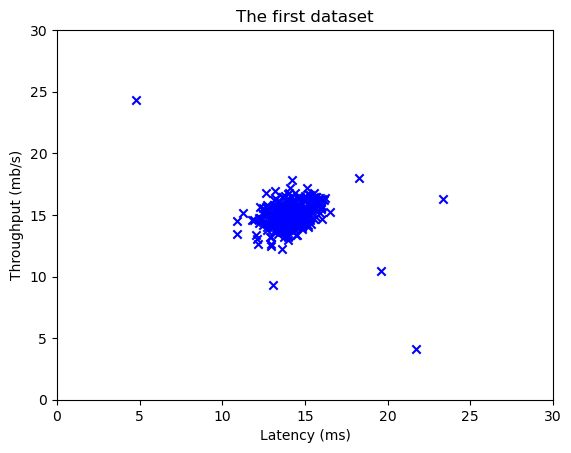

In [10]:
# Create a scatter plot of the data.
plt.scatter(X_train[:, 0], X_train[:, 1], marker='x', c='b')

# Set the title
plt.title("The first dataset")
# Set the y-axis label
plt.ylabel('Throughput (mb/s)')
# Set the x-axis label
plt.xlabel('Latency (ms)')
# Set axis range
plt.axis([0, 30, 0, 30])
plt.show()

## Gaussian Distribution
- To perform anomaly detection, we will 1st need to fit a model to the data's distribution.
    - Given a training set {x_1, x_2, ...x_m} we want to estimate the Gaussian distribution for each of the features x_i.
    - Recall that the Gaussian distribution is given by
        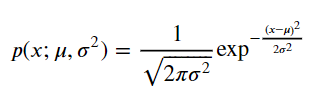
    - Where Mu is means and sigma^2 is variance
    - For each feature i = 1...n, we need to find the parameters Mu_i and sigma^2_i that fit the data in the i-the dimension {x_i(1),...x_i(m) }

In [12]:
def estimate_gaussain(X):
    """
    Calculate means and variance of all features in the dataset.
    
    Args : 
        X (ndarray) : (n,) Mean of all features
        var (ndarray) : (n,) variance of all features
    """
    
    m, n = X.shape
    
    mu = 1/m * np.sum(X, axis = 0)
    var = 1/m * np.sum((X - mu)**2, axis=0)
    
    return mu, var

In [13]:
mu, var = estimate_gaussain(X_train)

print("Mean of each feature : ", mu)
print("Variance of each feature : ", var)

Mean of each feature :  [14.11222578 14.99771051]
Variance of each feature :  [1.83263141 1.70974533]


- 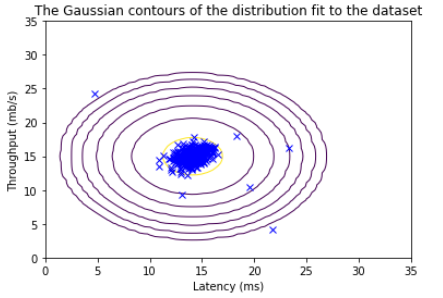
- We can see that most of the examples are in the region with the highest probability, while the anomalous examples are int he regions with lower probabilities

### Selecting the threshold (epsilon)
- Now that we have estimated the Gaussian parameters, we can investigate which examples have a very high probability given this distribution and which examples have a very low probability.
    - The low probability examples are more likely to be the anomalies in our dataset.
    - One way to determine which examples are anomalies is to select a threshold based on a cross validation set.
- We will compute the code in select_threshold to select the threshold using F1 score on a cross valdiatio set.
    - We will use a cross val;diation set {(x_cv(1), y_cv(1)....(x_cv(m), y_cv(m)}, where the label y = 1 corresponds to an anomolous example, and y = 0 corresponds to a normal example.
    - For each cross validation example, we will compute p(x_cv(i))

- If an example x has a low probabilit p(x) < threshold, the it is classidied as an anomaly
- Then, we can compute precision and recall by,
    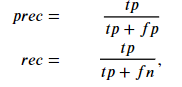
- The F1 score is computed using precision and recall as follows
    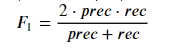

In [27]:
def multivariate_gaussian(X, mu, var):
    """
    Computes the probability 
    density function of the examples X under the multivariate gaussian 
    distribution with parameters mu and var. If var is a matrix, it is
    treated as the covariance matrix. If var is a vector, it is treated
    as the var values of the variances in each dimension (a diagonal
    covariance matrix
    """
    
    k = len(mu)
    
    if var.ndim == 1:
        var = np.diag(var)
        
    X = X - mu
    p = (2* np.pi)**(-k/2) * np.linalg.det(var)**(-0.5) * \
        np.exp(-0.5 * np.sum(np.matmul(X, np.linalg.pinv(var)) * X, axis=1))
    return p

In [28]:
def select_threshold(y_val, p_val): 
    """
    Finds the best threshold to use for selecting outliers 
    based on the results from a validation set (p_val) 
    and the ground truth (y_val)
    
    Args:
        y_val (ndarray): Ground truth on validation set
        p_val (ndarray): Results on validation set
        
    Returns:
        epsilon (float): Threshold chosen 
        F1 (float):      F1 score by choosing epsilon as threshold
    """ 

    best_epsilon = 0
    best_F1 = 0
    F1 = 0
    
    step_size = (max(p_val) - min(p_val)) / 1000
    
    for epsilon in np.arange(min(p_val), max(p_val), step_size):
    
        ### START CODE HERE ### 
        predictions = (p_val < epsilon)
        
        tp = np.sum((predictions == 1) & (y_val == 1))
        fp = np.sum((predictions == 1) & (y_val == 0))
        fn = np.sum((predictions == 0) & (y_val == 1))
        
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        
        F1 = (2*prec*rec) / (prec + rec)
        
        ### END CODE HERE ### 
        
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
        
    return best_epsilon, best_F1

In [29]:
p_val = multivariate_gaussian(X_val, mu, var)
epsilon, F1 = select_threshold(y_val, p_val)

print('Best epsilon found using cross-validation: %e' % epsilon)
print('Best F1 on Cross Validation Set: %f' % F1)

Best epsilon found using cross-validation: 8.990853e-05
Best F1 on Cross Validation Set: 0.875000


C:\Users\surya\AppData\Local\Temp\ipykernel_10932\1354929770.py:31: RuntimeWarning: invalid value encountered in scalar divide
  prec = tp / (tp + fp)


### High dimensional dataset

In [32]:
def load_data_multi():
    X = np.load("X_part2.npy")
    X_val = np.load("X_val_part2.npy")
    y_val = np.load("y_val_part2.npy")
    return X, X_val, y_val

In [33]:
# Load the dataset
X_train_high, X_val_high, y_val_high = load_data_multi()

In [34]:
print ('The shape of X_train_high is:', X_train_high.shape)
print ('The shape of X_val_high is:', X_val_high.shape)
print ('The shape of y_val_high is: ', y_val_high.shape)

The shape of X_train_high is: (1000, 11)
The shape of X_val_high is: (100, 11)
The shape of y_val_high is:  (100,)


In [36]:
# Estimate tghe Gaussian parameters
mu_high, var_high = estimate_gaussain(X_train_high)

# Evaluate the probabilites for the training set
p_high = multivariate_gaussian(X_train_high, mu_high, var_high)

# Evaluate the probabilites for the cross validation set
p_val_high = multivariate_gaussian(X_val_high, mu_high, var_high)

# Find the best threshold
epsilon_high, F1_high = select_threshold(y_val_high, p_val_high)

print('Best epsilon found using cross-validation: %e'% epsilon_high)
print('Best F1 on Cross Validation Set:  %f'% F1_high)
print('# Anomalies found: %d'% sum(p_high < epsilon_high))

Best epsilon found using cross-validation: 1.377229e-18
Best F1 on Cross Validation Set:  0.615385
# Anomalies found: 117


C:\Users\surya\AppData\Local\Temp\ipykernel_10932\1354929770.py:31: RuntimeWarning: invalid value encountered in scalar divide
  prec = tp / (tp + fp)
